## Texture vs Shape: introduction
(homework #2 for DNN 2024/25)

<div style="max-width: 60em">

In this homework, we will look at a modern residual convolutional net. While they perform very well on image classification tasks, some problems they commonly have are that:<br>
* they rely too much on small-scale features (textures) rather than large-scale ones (shape). This often generalizes poorly to unseen datasets and is less human-aligned (e.g. explanations of why a model chose this class may be less interpretable).
* they are very susceptible to adversarial images, i.e. inputs maliciously altered in a way that is imperceptible to humans and shouldn't change the classification, but completely fool the model, making it output high probabilities for unrelated classes.

While the two problems are somewhat related, we focus on the first one.
You are given a pre-trained model and datasets, as well as the code for standard evaluation and training loops, and for generating adversarial examples.
Your tasks (fully detailed in later cells) will be as follows:

0. Adapt a pretrained model to the smaller datasets by changing the classification layer.
1. Implement transformations (blur, pixelize, noise) that can help us elucidate and perhaps remedy the texture-bias problem.
2. Compare how the model handles them and how much they help as augmentations used in fine-tuning.
3. Read a paper about AdvProp: a relatively simple method for training models with less texture bias, using adversarial examples; implement and evaluate it.
4. Implement and evaluate SparseTopK: another, even simpler method proposed for the same problem: it just zeroes all but the top 20% activations in some layers.

Submission requirements:
* Please do not modify anything outside of the `### BEGIN SOLUTION ... ### END SOLUTION` blocks (if you feel it might be useful somewhere, ask on slack).
* Please make sure to submit your solution as a notebook with saved cell outputs.
* Don't use `tqdm.notebook` or `tqdm.auto`, just plain `tqdm`.
* It should be possible to execute the notebook from top to bottom when loaded in Colab with a GPU, in a reasonable amount of time.
* Plots should either be images embedded in cell outputs (in a way that shows correctly when loading the notebook from file, without executing it), or attached together with the exported .ipynb notebook in a .zip file  (screenshots are admissible, but prefer exporting with e.g. `plt.savefig()`).

</div>

## Imports

In [ ]:
import json
import multiprocessing
from collections.abc import Callable, Iterable, Sequence
from copy import deepcopy
from functools import partial
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import torch
import torch.nn
import torch.nn.functional as F
import torchvision.models
import torch.optim.lr_scheduler
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from tqdm import tqdm

### BEGIN SOLUTION
# Feel free to add more imports and global settings here, though none are necessary.
import plotly.graph_objects as go
from plotly.subplots import make_subplots
### END SOLUTION

%matplotlib inline

multiprocessing.set_start_method("spawn", force=True)  # Needed when using CUDA.
torch.set_num_threads(8)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    torch.cuda.set_device(2)

_ = torch.manual_seed(42)

## Datasets

In [ ]:
%%bash
# 219 MiB
if [ ! -d datasets ]; then
    gdown https://drive.google.com/uc?id=1NxbIDRe2SN91QGzNYtT_v38WkIFa-nix\
        && tar -xf datasets.tar.gz \
        && rm datasets.tar.gz
fi

##### MiniImageNet
MiniImageNet is a downscaled subset of ISVLRC ImageNet-1k<sup>[1]</sup> with only 10 classes (RGB, irregular sizes up to 256x256).
Train/val is a uniformly random split, the parts have 2000/100 images per class, respectively.

We will use the *train* part for fine-tuning and *val* for validation and various evaluation.

[1] https://www.kaggle.com/competitions/imagenet-object-localization-challenge/overview

['bear', 'bicycle', 'boat', 'bottle', 'car', 'cat', 'chair', 'clock', 'elephant', 'truck']


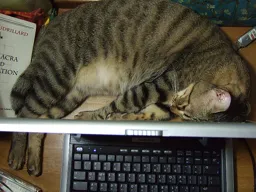

In [ ]:
MINI_IMAGENET_PATH = Path("datasets/miniImageNet")
SELECTED_CLASSES = ImageFolder(MINI_IMAGENET_PATH / "train").classes
assert SELECTED_CLASSES == ImageFolder(MINI_IMAGENET_PATH / "val").classes


def example() -> None:  # Note: we scope examples to avoid polluting the global namespace.
    print(SELECTED_CLASSES)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val")
    img, label = dataset[505]
    display(img)
    print(label, dataset.classes[label])


example()

##### eval_transform, display_image_tensor()

5 cat


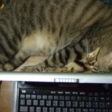

img.shape=torch.Size([3, 112, 112]), img.dtype=torch.float32, min..max=-2.015..2.64
label=5 (cat)


In [ ]:
def get_eval_transform() -> v2.Compose:
    """
    The default transform used on all ImageNet images before passing to a model.

    (Typically papers end up with 224x224 images, we make them smaller for speed.)
    """
    return v2.Compose(
        [
            v2.PILToTensor(),
            v2.Resize(size=128, antialias=True),
            v2.CenterCrop(size=(112, 112)),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
        ]
    )


def normalize(x: torch.Tensor) -> torch.Tensor:
    """Normalize an image tensor of shape (*B, C, H, W) from 0..1 values."""
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    return (x - mean) / std


def unnormalize(x: torch.Tensor) -> torch.Tensor:
    """Revert an image tensor of shape (*B, C, H, W) to 0..1 values."""
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    return x * std + mean


def display_image_tensor(x: torch.Tensor) -> None:
    """Display a normalized image tensor of shape (C, H, W) as a PIL Image."""
    pil_image: PIL.Image.Image = v2.ToPILImage()(unnormalize(x))
    display(pil_image)


def ceildiv(a: int, b: int) -> int:
    """Return ceil(a /b)."""
    return -(-a // b)


def example() -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[505]
    display_image_tensor(img)
    print(f"{img.shape=}, {img.dtype=}, min..max={img.min().item():.4g}..{img.max().item():.4g}")
    print(f"{label=} ({dataset.classes[label]})")


example()

##### alt_test_dataset
This is a dataset with the same classes and some of the same images, but restylized or otherwise altered to mislead models reliant on textures.
We will use this dataset to test if a training method results in a model that is less reliant on textures.
Note that some alterations are pretty heavy, so the images look very different and it is difficult to achieve more than ~40-50% accuracy.

RGB, 224x224, 280 images per class.

(The dataset was created from https://github.com/bethgelab/model-vs-human/releases/tag/v0.1)

cue-conflict 800, edge 100, low-pass 800, silhouette 100, sketch 500, stylized 500, total 2800


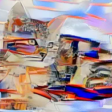

In [ ]:
ALT_TEST_DATASET_PATHS = sorted(Path("datasets/testSets").iterdir())
alt_test_dataset = ConcatDataset([ImageFolder(p, transform=get_eval_transform()) for p in ALT_TEST_DATASET_PATHS])


def example() -> None:
    for p in ALT_TEST_DATASET_PATHS:
        dataset = ImageFolder(p, transform=get_eval_transform())
        assert dataset.classes == SELECTED_CLASSES
        print(p.name, len(dataset), end=", ")
        # display_image_tensor(dataset[int(len(dataset) * 0.53)][0])
    print("total", len(alt_test_dataset))

    img, _label = alt_test_dataset[445]
    display_image_tensor(img)


example()

## Evaluate() and get_dataloader()

Here's an implementation of an evaluation loop, to be used in this notebook.

In [ ]:
def get_dataloader(
    dataset: Dataset,
    shuffle: bool = False,
    batch_size: int = 256,
    num_workers: int = 2,
    pin_memory: bool = True,
    prefetch_factor: int = 2,
    persistent_workers: bool = True,
    timeout: float = 30.0,
    **kwargs: Any,
) -> DataLoader:
    """DataLoader constructor with different defaults."""
    if num_workers == 0:
        pin_memory = False
        persistent_workers = False
        prefetch_factor = None
        timeout = 0.0

    return DataLoader(
        dataset,
        shuffle=shuffle,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        prefetch_factor=prefetch_factor,
        persistent_workers=persistent_workers,
        timeout=timeout,
        **kwargs,
    )

In [ ]:
def evaluate(
    model: torch.nn.Module,
    dataloader: Dataset | DataLoader,
    description: str = "eval",
    device: str = DEVICE,
    quiet: bool = False,
    use_workers: bool = True,
) -> float:
    """Evaluate a model on a dataset or dataloader, returning the accuracy (0..1)."""
    model = model.to(device).eval()
    if not isinstance(dataloader, DataLoader):  # Create from dataset.
        if use_workers:
            dataloader = get_dataloader(dataloader, persistent_workers=False)
        else:
            dataloader = get_dataloader(dataloader, num_workers=0)

    accuracy, n_done, n_correct = 0, 0, 0

    progress_bar = tqdm(dataloader, desc=description, disable=quiet, delay=0.5)
    with torch.no_grad(), progress_bar:
        for image_batch, label_batch in progress_bar:
            logits_batch = model(image_batch.to(device))
            predictions = logits_batch.argmax(dim=1)

            n_done += len(label_batch)
            n_correct += (predictions == label_batch.to(device)).sum().item()
            accuracy = n_correct / n_done if n_done else 0
            progress_bar.set_postfix({"accuracy": f"{accuracy * 100:.1f} %"})

    return accuracy

## Task 0: Model, remapping the classification layer

We will use a ready-made model pretrained on ImageNet-1k.<br>
Since they all output logits for 1000 classes (`IMAGENET_CATEGORIES`),<br>
we need to alter the classification layer to output logits for the 10 MiniImageNet classes instead (`SELECTED_CLASSES`).<br>
Note that several ImageNet-1k classes can map to the same MiniImageNet class.<br>

Your task is to complete the implementation of `remap_output_layer()` below,<br>
so that the model works without any fine-tuning/training of the last layer.<br>
In `example_remapping()` below (which evaluates the model on the val dataset),<br>
you should achieve at least 70% accuracy and finish in under 35 seconds on Colab CPU (~15s on GPU).<br>

In [ ]:
SELECTED_MODEL = (torchvision.models.efficientnet_b0, torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)
# 5.3M params, 78% acc@1 on original ImageNet-1k

# Other models we considered, but cut for time:
# * (torchvision.models.mobilenet_v3_small, torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
#     2.5M params, 68% acc@1
# * (torchvision.models.resnet18, torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
#     11.7M params, 70% acc@1 on original ImageNet-1k
# * (torchvision.models.efficientnet_v2_s, torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
#     21.5M params, 84% acc@1

IMAGENET_CATEGORIES = SELECTED_MODEL[1].meta["categories"]
assert IMAGENET_CATEGORIES == torchvision.models.ResNet18_Weights.IMAGENET1K_V1.meta["categories"]
print(len(IMAGENET_CATEGORIES), ", ".join(IMAGENET_CATEGORIES[:7] + ["..."]))

1000 tench, goldfish, great white shark, tiger shark, hammerhead, electric ray, stingray, ...


In [ ]:
# Some technical details, feel free to ignore.


def _load_imagenet_id_to_class_id_map(classes: Sequence[str] = SELECTED_CLASSES) -> dict[int, int]:
    """
    Return a map from imagenet ids 0..999 to selected class ids: 0..len(classes)-1.

    Classes should be a subset of the following 16 class names:
        airplane,bear,bicycle,bird,boat,bottle,car,cat,chair,clock,dog,elephant,keyboard,knife,oven,truck
    """
    imagenet_id_to_name = {i: name for i, name in enumerate(IMAGENET_CATEGORIES)}
    class_to_idx = {name: i for i, name in enumerate(classes)}
    with open("datasets/imagenet_name_to_synset_id.json") as f:
        name_to_synset = json.load(f)
    with open("datasets/synset_id_to_class.json") as f:
        synset_to_class = json.load(f)
    # Not all synsets defined in synset_id_to_class.json are present in ImageNet-1k
    # (they also don't appear in our dataset 10-class-ImageNet).
    imagenet_name_to_class_name = {
        name: synset_to_class[synset] for name, synset in name_to_synset.items() if synset in synset_to_class
    }

    result = dict[int, int]()
    for imagenet_id, imagenet_name in imagenet_id_to_name.items():
        # Not all imagenet names are present in 10-class-ImageNet, obviously.
        if imagenet_name in imagenet_name_to_class_name:
            class_name = imagenet_name_to_class_name[imagenet_name]
            # Not all class names defined for 16-class-ImageNet are present in our dataset 10-class-ImageNet.
            if class_name in class_to_idx:
                result[imagenet_id] = class_to_idx[class_name]

    for k, v in result.items():
        assert 0 <= k < len(IMAGENET_CATEGORIES) and 0 <= v < len(classes)

    return result


def _reset_model_weights(model: torch.nn.Module) -> None:
    """Reinitialize the model weights randomly. We probably won't use it."""
    # Some models define reset_parameters(), but unfortunately not all.
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, mode="fan_out")
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        elif isinstance(m, torch.nn.BatchNorm2d | torch.nn.GroupNorm):
            torch.nn.init.ones_(m.weight)
            torch.nn.init.zeros_(m.bias)
        elif isinstance(m, torch.nn.Linear):
            init_range = 1.0 / np.sqrt(m.out_features)
            torch.nn.init.uniform_(m.weight, -init_range, init_range)  # EfficientNet v1
            # torch.nn.init.normal_(m.weight, 0, 0.01)  # MobileNet v3
            torch.nn.init.zeros_(m.bias)

In [ ]:
def remap_output_layer(layer: torch.nn.Linear, id_map: dict[int, int]) -> torch.nn.Module:
    """Return a new final classification logit layer where the i-th class becomes id_map[i] instead."""
    assert layer.out_features == len(IMAGENET_CATEGORIES)

    ### BEGIN SOLUTION
    new_layer = torch.nn.Linear(layer.in_features, layer.out_features)
    with torch.no_grad():
        new_weights = torch.zeros_like(layer.weight).to(DEVICE)
        new_bias = torch.zeros_like(layer.bias).to(DEVICE)

        for old_idx, new_idx in id_map.items():
            new_weights[new_idx] = layer.weight[old_idx]
            new_bias[new_idx] = layer.bias[old_idx]

        new_layer.weight.copy_(new_weights)
        new_layer.bias.copy_(new_bias)

    return new_layer
    ### END SOLUTION

In [ ]:
def get_model(
    eval: bool = False, reset: bool = False, selected_classes: Sequence[str] = SELECTED_CLASSES
) -> torch.nn.Module:
    model_fn, model_weights = SELECTED_MODEL
    model = model_fn(weights=model_weights).to(DEVICE)

    # Find and replace the last Linear layer.
    id_map = _load_imagenet_id_to_class_id_map(selected_classes)
    last_linear_layer = None
    for parent_module in model.modules():
        for name, layer in parent_module.named_children():
            if isinstance(layer, torch.nn.Linear):
                last_linear_layer = (parent_module, name, layer)
    assert last_linear_layer is not None
    parent_module, name, layer = last_linear_layer

    setattr(parent_module, name, remap_output_layer(layer, id_map))

    if reset:
        _reset_model_weights(model)

    return model.eval() if eval else model.train()


get_model(eval=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 109MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
def example_remapping() -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    model = get_model(eval=True)
    evaluate(model, dataset)


example_remapping()

eval: 100%|██████████| 4/4 [00:10<00:00,  2.52s/it, accuracy=75.3 %]


## Training

Here's an implementation of a training loop that we will use for this notebook.
You should not need to alter hyperparameters, use the defaults of `Trainer.__init__()`.

In [ ]:
BATCH_NORM_TYPES = (
    torch.nn.BatchNorm1d
    | torch.nn.BatchNorm2d
    | torch.nn.BatchNorm3d
    | torch.nn.SyncBatchNorm
    | torch.nn.LazyBatchNorm1d
    | torch.nn.LazyBatchNorm2d
    | torch.nn.LazyBatchNorm3d
)


class Trainer:
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = DEVICE,
        extra_augmentation: v2.Transform | None = None,
        use_workers: bool = True,
    ):
        self.lr = lr
        self.weight_decay = weight_decay
        self.n_epochs = n_epochs
        self.device = device
        self.batch_norm_momentum = batch_norm_momentum
        if extra_augmentation is not None:
            self.extra_augmentation = v2.RandomApply([extra_augmentation], p=0.5)
        else:
            self.extra_augmentation = v2.GaussianBlur(kernel_size=9, sigma=(0.1, 9.0))
        self.num_workers = 2 if use_workers else 0

    def get_train_transform(self) -> v2.Transform:
        return v2.Compose(
            [
                v2.PILToTensor(),
                v2.RandomResizedCrop(size=(112, 112), antialias=True),
                v2.RandomHorizontalFlip(p=0.5),
                v2.AutoAugment(interpolation=v2.InterpolationMode.BILINEAR),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
                self.extra_augmentation,
                v2.RandomErasing(p=0.2),
                v2.ToPureTensor(),
            ]
        )

    def get_train_dataloader(self) -> DataLoader:
        transform = self.get_train_transform()
        train_dataset = ImageFolder(MINI_IMAGENET_PATH / "train", transform=transform)
        return get_dataloader(train_dataset, shuffle=True, num_workers=self.num_workers)

    def get_eval_dataloaders(self) -> dict[str, DataLoader]:
        transform = get_eval_transform()
        val_dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=transform)
        return {
            "val": get_dataloader(val_dataset, num_workers=self.num_workers),
            "alt": get_dataloader(alt_test_dataset, num_workers=self.num_workers),
        }

    def get_optimizer_and_scheduler(
        self, parameters: Iterable[torch.nn.Parameter]
    ) -> tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LRScheduler]:
        optimizer = torch.optim.AdamW(parameters, lr=self.lr, weight_decay=self.weight_decay, fused=True)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
        return optimizer, lr_scheduler

    def do_evaluations(self, model: torch.nn.Module, eval_dataloaders: dict[str, DataLoader]) -> dict[str, float]:
        result = dict[str, float]()
        for k, d in eval_dataloaders.items():
            result[k] = evaluate(model, d, description=k, quiet=True)
            print(f"{k}={result[k] * 100:.1f} %", end="\t", flush=True)
        print()
        return result

    def train(self, model: torch.nn.Module) -> dict[str, list[float]]:
        model = model.to(self.device)

        if self.batch_norm_momentum is not None:
            # Default torch.nn.BatchNorm2D.momentum is 0.1, but it's often too high.
            for m in model.modules():
                if isinstance(m, BATCH_NORM_TYPES):
                    m.momentum = self.batch_norm_momentum

        train_dataloader = self.get_train_dataloader()
        eval_dataloaders = self.get_eval_dataloaders()
        optimizer, lr_scheduler = self.get_optimizer_and_scheduler(model.parameters())

        results = {k: [] for k in eval_dataloaders.keys()}
        for k, v in self.do_evaluations(model, eval_dataloaders).items():
            results[k].append(v)

        for epoch in range(1, self.n_epochs + 1):
            self.train_epoch(model, train_dataloader, optimizer, epoch)
            lr_scheduler.step()

            for k, v in self.do_evaluations(model, eval_dataloaders).items():
                results[k].append(v)

        return results

    def train_epoch(
        self, model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, epoch: int
    ) -> None:
        model.train()
        n_correct = 0
        n_total = 0
        progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")
        for image_batch, label_batch in progress_bar:
            image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)

            optimizer.zero_grad()
            logits_batch = model(image_batch)
            loss = torch.nn.CrossEntropyLoss()(logits_batch, label_batch)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                n_correct += (logits_batch.argmax(dim=1) == label_batch).sum().item()
                n_total += len(label_batch)
            accuracy = n_correct / n_total
            progress_bar.set_postfix({"train-acc": f"{accuracy * 100:.1f} %", "lr": optimizer.param_groups[0]["lr"]})


## Task 1: Implementing augmentations

In this task, you are asked to implement a few transformations that can help in assessing whether a model relies more on texture or shape information.

Consider using functions from [torch.nn.functional](https://pytorch.org/docs/stable/nn.functional.html), in particular [vision](https://pytorch.org/docs/stable/nn.functional.html#vision-functions), [convolution](https://pytorch.org/docs/stable/nn.functional.html#convolution-functions), and [pooling](https://pytorch.org/docs/stable/nn.functional.html#pooling-functions) functions (or corresponding modules in `torch.nn`).

In all cases, the transform should take a normalized image of shape `(*B, C, H, W)` (where `*B` represents any number of extra dimensions, possibly none) and dtype `float32`, and it should output the same.
Do not change the tensor's device (it will be CPU).

Use the following functions to check and benchmark your transforms. Each benchmark should take <20s (on Colab CPU, the GPU is not used here even if available).

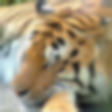

In [ ]:
def example_transformed(transform: Callable[[torch.Tensor], torch.Tensor], image_id: int = 510, seed: int = 42) -> None:
    torch.manual_seed(seed)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[image_id]
    with torch.no_grad():
        img = transform(img)
    display_image_tensor(img)


def benchmark_transform(transform: v2.Transform) -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "train", transform=transform)
    dataset = Subset(dataset, range(2500))
    dataloader = get_dataloader(dataset, batch_size=256, num_workers=0)
    for _image_batch, _label_batch in tqdm(dataloader):
        pass


example_transformed(v2.GaussianBlur(kernel_size=25, sigma=2.0), 513)

#### 1a: Blur
Implement a transformation that blurs the image (any method that makes the image visually smoother in all directions is fine).<br>
The transform should be parameterized by strength (from roughly 1 meaning no/minimal blurring to 100 meaning the image becomes unrecognizable to humans).<br>
For task 1a specifically, do not use any library beyond `torch.*` and python built-ins (in particular, do not use `torchvision`'s `GaussianBlur`).<br>

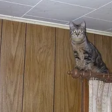

In [ ]:
def blur(x: torch.Tensor, strength: int = 10) -> torch.Tensor:
    assert 1 <= strength <= 100, f"Expected 1 ≤ strength ≤ 100, got {strength}."
    *B, C, H, W = x.shape
    ### BEGIN SOLUTION
    # Compute kernel size depends on strength
    max_kernel_size = min(H, W)
    kernel_size = int(1 + (strength / 132) ** 2 * (max_kernel_size - 1))
    kernel_size = kernel_size if kernel_size % 2 == 1 else kernel_size + 1
    padding = kernel_size // 2

    # First kernel for vertical pool
    kernel_1 = torch.ones((C, 1, 1, kernel_size)) / kernel_size
    x = F.pad(x, (padding, padding, 0, 0), mode="replicate")
    x = F.conv2d(x, kernel_1, groups=C)

    # Second kernel for horizontal pool
    kernel_2 = torch.ones((C, 1, kernel_size, 1)) / kernel_size
    x = F.pad(x, (0, 0, padding, padding), mode="replicate")
    x = F.conv2d(x, kernel_2, groups=C)
    ### END SOLUTION
    return x


example_transformed(blur, 507)

In [ ]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(blur)]))

100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


#### 1b: Pixelize
Implement a transformation that averages blocks of `block_height x block_width` pixels, as in the example below.

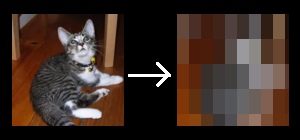

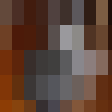

In [ ]:
def pixelize(x: torch.Tensor, block_height: int = 8, block_width: int = 8) -> torch.Tensor:
    assert 1 <= block_height and 1 <= block_width, f"Expected ≥1, got {block_height=}, {block_width=}."
    ### BEGIN SOLUTION
    add_dimension = False
    if x.dim() == 3:
        add_dimension = True
        x = x.unsqueeze(0)

    N, C, H, W = x.shape
    padded_H = (H + block_height - 1) // block_height * block_height
    padded_W = (W + block_width - 1) // block_width * block_width

    # Padding image
    pad_H = padded_H - H
    pad_W = padded_W - W
    x = F.pad(x, (0, pad_W, 0, pad_H), mode='replicate')

    # Compute mean for each block
    new_H = padded_H // block_height
    new_W = padded_W // block_width
    x = x.view(N, C, new_H, block_height, new_W, block_width).mean(dim=(3, 5))

    # Back to original dimension
    x = x.repeat_interleave(block_height, dim=2).repeat_interleave(block_width, dim=3)
    x = x[:, :C, :H, :W]

    if add_dimension:
        x = x.squeeze(0)
    ### END SOLUTION
    return x


example_transformed(lambda x: pixelize(x, 25, 12), 510)

In [ ]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(pixelize)]))

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


#### 1c: Noise

Implement a transformation that adds noise (same on each channel, up to normalization constants) to an image.<br>
Any kind of noise like that is fine, but it should be parameterized by noise strength (from 1 unnoticeable to 100 unrecognizable) and grain size (roughly in pixels), as in the four examples below.<br>

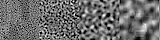

In [ ]:
def noise(x: torch.Tensor, strength: int = 25, grain_size: int = 5) -> torch.Tensor:
    assert 1 <= strength <= 100, f"Expected 1 ≤ strength ≤ 100, got {strength}."
    assert 1 <= grain_size <= 100, f"Expected 1 ≤ grain_size ≤ 100, got {grain_size}."
    ### BEGIN SOLUTION
    add_dimension = False
    if x.dim() == 3:
        x = x.unsqueeze(0)
        add_dimension = True

    minimum, maximum = x.amin(dim=(1, 2, 3), keepdim=True), x.amax(dim=(1, 2, 3), keepdim=True)

    # Compute noise dimensions
    N, C, H, W = x.shape
    noise_std = (strength / 40.0) ** 2
    grain_h = max(1, 2 * H // grain_size)
    grain_w = max(1, 2 * W // grain_size)

    # Generate noise
    noise = torch.randn((1, 1, grain_h, grain_w)) * noise_std
    noise = F.interpolate(
        noise, size=(H, W), mode="bicubic", align_corners=True
    )
    x = x + noise.expand(N, C, H, W)

    # Back to original shape and color
    x_min, x_max = x.amin(dim=(1, 2, 3), keepdim=True), x.amax(dim=(1, 2, 3), keepdim=True)
    x = (x - x_min) / (x_max - x_min) * (maximum - minimum) + minimum
    x = torch.clamp(x, -1.28, 1.27)
    if add_dimension:
        x = x.squeeze(0)
    ### END SOLUTION
    return x

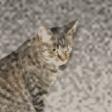

In [ ]:
example_transformed(noise, 506)

In [ ]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(noise)]))

100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


## Task 2: Comparing augmentations

Focus on the readability of the presented results.

Note: to use transforms defined in a notebook, you will have to call `evaluate()` with `use_workers=False`<br>
(this is because functions are pickled by reference, and those defined in a notebook cannot be imported by workers spawned by a dataloader;<br>
other workarounds include writing a Python module e.g. with `%%writefile file.py`, or using the `cloudpickle` package, but we prefer to keep it simple here).

#### Side note: lambdas in for loops

Since in this task it may be useful to use lots of lambdas (to change default parameters in your transformations),<br>
we would like to warn about one potential pitfall here.<br>

One 'gotcha' in Python is that 'for' variables (and similar blocks) are not scoped to the loop body,<br>
they continue with the value from the last iteration.

In [ ]:
def example() -> None:
    for i in range(3):
        for j in range(3):
            pass
        print(j)


example()

2
2
2


This is sometimes useful and mostly benign, but we may overlook using the wrong variable.

Another gotcha is that closures in Python (lambdas or def-s using variables from external scopes)<br>
are *late-binding*, meaning variables are captured by reference,<br>
so especially together with the previous gotcha, we get a probably-not-so-intuitive result:

In [ ]:
def example() -> None:
    funcs = [(lambda x: x + a) for a in range(3)]
    for f in funcs:
        print(f(0))


example()

2
2
2


Use `lambda x, a=a: f(x,a)` or `functools.partial(f, a=a)` to capture by value instead.

(A linter like [ruff](https://docs.astral.sh/ruff/) will warn you about both gotchas, by detecting e.g. [unused loop variables](https://docs.astral.sh/ruff/rules/unused-loop-control-variable/) and [loop variables used in closures](https://docs.astral.sh/ruff/rules/function-uses-loop-variable/), unfortunately there is no easy way to use them in Colab).

#### 2a: On vanilla model

Compare how `get_model()` performs on inputs from the `val` dataset, when transformed with your transformations (one at a time) or with `v2.GaussianBlur`, using different transform parameters.
(Use each transformation after `get_eval_transform()`, as in the benchmarks above.)

Plot the results. The total time taken by computations for this subtask must not exceed 10 minutes (on Colab GPU)<br>
(use fewer than 100 calls to evaluate(); if running on CPU, expect less than 40 minutes).<br>
Discuss the results in 2-4 sentences.

In [ ]:
### BEGIN SOLUTION

In [ ]:
# Dataset with tranformations
class TransformedDataset(Dataset):
    def __init__(self, dataset, transformation, **params):
        self.dataset = dataset
        self.transformation = transformation
        self.params = params

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        transformed_img = self.transformation(img, **self.params)
        return transformed_img, label


# Evaluate model on tranformed dateset
def evaluate_with_transform(dataset, transformation, **params):
    model = get_model()
    if isinstance(transformation, type):
        transform_instance = transformation(**params)
        transformed_dataset = TransformedDataset(dataset, lambda x: transform_instance(x))
    else:
        transformed_dataset = TransformedDataset(dataset, transformation, **params)

    transformed_loader = get_dataloader(
        transformed_dataset, shuffle=False, num_workers=0
    )
    return evaluate(model, transformed_loader)


# Parameters to check
blur_strengths = [1, 16, 32, 50, 70, 100]
noise_strengths = [1, 16, 32, 50, 64, 100]
sizes = [1, 2, 4, 8, 16]
kernel_sizes = [1, 5, 13, 29]
sigmas = [1.0, 4.0, 8.0, 16.0]

# Store results
results = {"blur": [], "pixelize": [], "noise": [], "gaussian": []}

# Test blur
val = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())

for strength in blur_strengths:
    print(f"The result of blurring with a strength of {strength}")
    results["blur"].append(
        evaluate_with_transform(val, blur, strength=strength)
    )

# Test pixelize
for height in sizes:
    for width in sizes:
        print(f"The result of pixelization with a shape of {height} by {width}")
        results["pixelize"].append(
            evaluate_with_transform(val, pixelize, block_height=height, block_width=width)
        )

# Test noise
for strength in noise_strengths:
    for size in sizes:
        print(f"The result of adding noise with a strength of {strength} and size {size}")
        results["noise"].append(
            evaluate_with_transform(val, noise, strength=strength, grain_size=size)
        )

# Test gaussian
for size in kernel_sizes:
    for sigma in sigmas:
        print(f"The result of adding gaussian blur with a kernel size of {size} and sigma of {sigma}")
        results["gaussian"].append(
            evaluate_with_transform(val, v2.GaussianBlur, kernel_size=size, sigma=sigma)
        )


# Subplot for each transformation type
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=["Blur Transformation", "Pixelize Transformation",
                    "Noise Transformation", "GaussianBlur Transformation"],
    horizontal_spacing=0.15, vertical_spacing=0.2
)

# Plot Blur results
fig.add_trace(
    go.Scatter(
        x=blur_strengths,
        y=results["blur"],
        mode="lines+markers",
        name="Blur",
        line=dict(color='blue')
    ),
    row=1, col=1
)

# Plot Pixelize results
pixel_sizes = [f"{h}x{w}" for h in sizes for w in sizes]
fig.add_trace(
    go.Scatter(
        x=pixel_sizes,
        y=results["pixelize"],
        mode="lines+markers",
        name="Pixelize",
        line=dict(color="orange")
    ),
    row=1, col=2
)

# Plot Noise results
noise_params = [f"{s}-{float(g)}" for s in noise_strengths for g in sizes]
fig.add_trace(
    go.Scatter(
        x=noise_params,
        y=results["noise"],
        mode="lines+markers",
        name="Noise",
        line=dict(color="green")
    ),
    row=2, col=1
)

# Plot GaussianBlur results
gaussian_params = [f"{k}-{sigma}" for k in kernel_sizes for sigma in sigmas]
fig.add_trace(
    go.Scatter(
        x=gaussian_params,
        y=results["gaussian"],
        mode="lines+markers",
        name="GaussianBlur",
        line=dict(color="red")
    ),
    row=2, col=2
)

# Show plot
fig.update_layout(
    title="Transformation Results on images",
    height=1000,
    width=1500,
    showlegend=False,
    template="plotly_dark"
)

fig.update_xaxes(title_text="Strength", row=1, col=1)
fig.update_xaxes(title_text="Height x Width", row=1, col=2)
fig.update_xaxes(title_text="Strength-Grain", row=2, col=1)
fig.update_xaxes(title_text="Kernel-Sigma", row=2, col=2)
fig.update_yaxes(title_text="Accuracy", title_standoff=12)

fig.show()

The result of blurring with a strength of 1


eval: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, accuracy=75.3 %]


The result of blurring with a strength of 16


eval: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it, accuracy=69.5 %]


The result of blurring with a strength of 32


eval: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it, accuracy=58.5 %]


The result of blurring with a strength of 50


eval: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, accuracy=36.5 %]


The result of blurring with a strength of 70


eval: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it, accuracy=26.8 %]


The result of blurring with a strength of 100


eval: 100%|██████████| 4/4 [00:08<00:00,  2.06s/it, accuracy=17.7 %]


The result of pixelization with a shape of 1 by 1


eval: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it, accuracy=75.3 %]


The result of pixelization with a shape of 1 by 2


eval: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it, accuracy=68.0 %]


The result of pixelization with a shape of 1 by 4


eval: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it, accuracy=54.9 %]


The result of pixelization with a shape of 1 by 8


eval: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it, accuracy=31.6 %]


The result of pixelization with a shape of 1 by 16


eval: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it, accuracy=16.6 %]


The result of pixelization with a shape of 2 by 1


eval: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=69.1 %]


The result of pixelization with a shape of 2 by 2


eval: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=38.8 %]


The result of pixelization with a shape of 2 by 4


eval: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it, accuracy=36.0 %]


The result of pixelization with a shape of 2 by 8


eval: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it, accuracy=22.8 %]


The result of pixelization with a shape of 2 by 16


eval: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it, accuracy=16.9 %]


The result of pixelization with a shape of 4 by 1


eval: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it, accuracy=55.7 %]


The result of pixelization with a shape of 4 by 2


eval: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it, accuracy=29.7 %]


The result of pixelization with a shape of 4 by 4


eval: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it, accuracy=30.3 %]


The result of pixelization with a shape of 4 by 8


eval: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it, accuracy=24.4 %]


The result of pixelization with a shape of 4 by 16


eval: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it, accuracy=17.1 %]


The result of pixelization with a shape of 8 by 1


eval: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it, accuracy=30.9 %]


The result of pixelization with a shape of 8 by 2


eval: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it, accuracy=22.1 %]


The result of pixelization with a shape of 8 by 4


eval: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it, accuracy=22.1 %]


The result of pixelization with a shape of 8 by 8


eval: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it, accuracy=21.0 %]


The result of pixelization with a shape of 8 by 16


eval: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it, accuracy=17.5 %]


The result of pixelization with a shape of 16 by 1


eval: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it, accuracy=18.1 %]


The result of pixelization with a shape of 16 by 2


eval: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it, accuracy=18.3 %]


The result of pixelization with a shape of 16 by 4


eval: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it, accuracy=16.5 %]


The result of pixelization with a shape of 16 by 8


eval: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it, accuracy=16.5 %]


The result of pixelization with a shape of 16 by 16


eval: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it, accuracy=20.2 %]


The result of adding noise with a strength of 1 and size 1


eval: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it, accuracy=72.4 %]


The result of adding noise with a strength of 1 and size 2


eval: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it, accuracy=72.3 %]


The result of adding noise with a strength of 1 and size 4


eval: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it, accuracy=72.3 %]


The result of adding noise with a strength of 1 and size 8


eval: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it, accuracy=72.4 %]


The result of adding noise with a strength of 1 and size 16


eval: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it, accuracy=72.3 %]


The result of adding noise with a strength of 16 and size 1


eval: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it, accuracy=73.2 %]


The result of adding noise with a strength of 16 and size 2


eval: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it, accuracy=71.5 %]


The result of adding noise with a strength of 16 and size 4


eval: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it, accuracy=66.8 %]


The result of adding noise with a strength of 16 and size 8


eval: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it, accuracy=70.7 %]


The result of adding noise with a strength of 16 and size 16


eval: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it, accuracy=72.9 %]


The result of adding noise with a strength of 32 and size 1


eval: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it, accuracy=55.4 %]


The result of adding noise with a strength of 32 and size 2


eval: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it, accuracy=49.1 %]


The result of adding noise with a strength of 32 and size 4


eval: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it, accuracy=27.9 %]


The result of adding noise with a strength of 32 and size 8


eval: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it, accuracy=36.7 %]


The result of adding noise with a strength of 32 and size 16


eval: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it, accuracy=60.0 %]


The result of adding noise with a strength of 50 and size 1


eval: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it, accuracy=28.7 %]


The result of adding noise with a strength of 50 and size 2


eval: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it, accuracy=21.4 %]


The result of adding noise with a strength of 50 and size 4


eval: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it, accuracy=16.9 %]


The result of adding noise with a strength of 50 and size 8


eval: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it, accuracy=18.0 %]


The result of adding noise with a strength of 50 and size 16


eval: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it, accuracy=27.3 %]


The result of adding noise with a strength of 64 and size 1


eval: 100%|██████████| 4/4 [00:05<00:00,  1.50s/it, accuracy=18.5 %]


The result of adding noise with a strength of 64 and size 2


eval: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it, accuracy=12.8 %]


The result of adding noise with a strength of 64 and size 4


eval: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it, accuracy=12.1 %]


The result of adding noise with a strength of 64 and size 8


eval: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it, accuracy=12.6 %]


The result of adding noise with a strength of 64 and size 16


eval: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it, accuracy=14.0 %]


The result of adding noise with a strength of 100 and size 1


eval: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it, accuracy=10.3 %]


The result of adding noise with a strength of 100 and size 2


eval: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it, accuracy=10.0 %]


The result of adding noise with a strength of 100 and size 4


eval: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it, accuracy=10.0 %]


The result of adding noise with a strength of 100 and size 8


eval: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it, accuracy=11.1 %]


The result of adding noise with a strength of 100 and size 16


eval: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it, accuracy=9.7 %]


The result of adding gaussian blur with a kernel size of 1 and sigma of 1.0


eval: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=75.3 %]


The result of adding gaussian blur with a kernel size of 1 and sigma of 4.0


eval: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it, accuracy=75.3 %]


The result of adding gaussian blur with a kernel size of 1 and sigma of 8.0


eval: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it, accuracy=75.3 %]


The result of adding gaussian blur with a kernel size of 1 and sigma of 16.0


eval: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it, accuracy=75.3 %]


The result of adding gaussian blur with a kernel size of 5 and sigma of 1.0


eval: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it, accuracy=68.5 %]


The result of adding gaussian blur with a kernel size of 5 and sigma of 4.0


eval: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it, accuracy=63.6 %]


The result of adding gaussian blur with a kernel size of 5 and sigma of 8.0


eval: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it, accuracy=63.6 %]


The result of adding gaussian blur with a kernel size of 5 and sigma of 16.0


eval: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it, accuracy=63.3 %]


The result of adding gaussian blur with a kernel size of 13 and sigma of 1.0


eval: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it, accuracy=68.3 %]


The result of adding gaussian blur with a kernel size of 13 and sigma of 4.0


eval: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it, accuracy=45.5 %]


The result of adding gaussian blur with a kernel size of 13 and sigma of 8.0


eval: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it, accuracy=42.9 %]


The result of adding gaussian blur with a kernel size of 13 and sigma of 16.0


eval: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it, accuracy=42.6 %]


The result of adding gaussian blur with a kernel size of 29 and sigma of 1.0


eval: 100%|██████████| 4/4 [00:53<00:00, 13.47s/it, accuracy=68.3 %]


The result of adding gaussian blur with a kernel size of 29 and sigma of 4.0


eval: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it, accuracy=42.9 %]


The result of adding gaussian blur with a kernel size of 29 and sigma of 8.0


eval: 100%|██████████| 4/4 [00:10<00:00,  2.61s/it, accuracy=29.3 %]


The result of adding gaussian blur with a kernel size of 29 and sigma of 16.0


eval: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it, accuracy=27.1 %]


**Discussion**:


As can be seen from the plots, Gaussian blur is the transformation that degrades accuracy the least, with sigma playing a more significant role than kernel size. For pixelation, smaller and more uniform dimensions have less negative impact on prediction. On the other hand, noise addition has the greatest impact on prediction, with the ratio of strength to size being a crucial parameter: larger sizes with low strength maintain reasonable accuracy, but beyond a certain threshold, predictions decrease sharply.

In [ ]:
### END SOLUTION

#### 2b: Fine-tuning

Consider the following set of transformations: `{v2.Identity(), noise(strength=25, grain_size=3), v2.GaussianBlur(kernel_size=7, sigma=5)}`.

Compare how models fine-tuned for 3 epochs with each augmentation from that set<br>
(one at a time, using `Trainer(extra_augmentation=..., n_epochs=3)`, with `use_workers=False` if `noise` is used)<br>
performs on val with each augmentation from that set, and on the alt dataset with zero augmentations.<br>
We don't expect computations to take more than 20 minutes in total, for this subtask (on Colab GPU; CPU is too slow for fine-tuning, ~20min per epoch).

Present the `3 x 4` results in a table. Discuss the results in 1-2 sentences.

In [ ]:
### BEGIN SOLUTION

In [ ]:
# Augmentations for training
augmentations = {
    "identity": v2.Identity(),
    "noise": v2.Lambda(lambda x: noise(x, strength=25, grain_size=3)),
    "gaussian_blur": v2.GaussianBlur(kernel_size=7, sigma=5),
}

# Datasets with transformations
datasets = {
    "identity": ImageFolder(
        MINI_IMAGENET_PATH / "val",
        transform=v2.Compose([get_eval_transform(), v2.Identity()])
    ),
    "noise": ImageFolder(
        MINI_IMAGENET_PATH / "val",
        transform=v2.Compose([get_eval_transform(), v2.Lambda(lambda x: noise(x, strength=25, grain_size=3))])
    ),
    "gaussian_blur": ImageFolder(
        MINI_IMAGENET_PATH / "val",
        transform=v2.Compose([get_eval_transform(), v2.GaussianBlur(kernel_size=7, sigma=5.0)])
    ),
    "alt_dataset": alt_test_dataset
}

# Result dictionary
results = {}

# Models fine-tuned for 3 epochs
for train_aug_name, train_augmentation in augmentations.items():
    print(f"Training with {train_aug_name} augmentation:")
    model = get_model(eval=False)
    trainer = Trainer(extra_augmentation=train_augmentation, n_epochs=3, use_workers=(train_aug_name != "noise"))
    trainer.train(model)

    # Evaluate the trained model on all datasets
    eval_results = []
    for eval_dataset_name, eval_dataset in datasets.items():
        eval_results.append(evaluate(model, eval_dataset, use_workers=(eval_dataset_name != "noise")))

    results[train_aug_name] = eval_results

# Display results as dataframe
results_df = pd.DataFrame(results, index=["identity", "noise", "gaussian_blur", "alt_dataset"])
print("\n")
print("Results of fine-tune:")
results_df.transpose(copy=False).style

Training with identity augmentation:
val=75.3 %	alt=36.8 %	


Train epoch   1: 100%|██████████| 79/79 [01:07<00:00,  1.17it/s, train-acc=80.2 %, lr=0.0002]


val=92.2 %	alt=48.8 %	


Train epoch   2: 100%|██████████| 79/79 [01:01<00:00,  1.28it/s, train-acc=86.2 %, lr=0.000194]


val=94.0 %	alt=50.8 %	


Train epoch   3: 100%|██████████| 79/79 [01:01<00:00,  1.29it/s, train-acc=87.8 %, lr=0.000188]


val=95.2 %	alt=50.4 %	


eval: 100%|██████████| 11/11 [00:13<00:00,  1.22s/it, accuracy=50.4 %]


Training with noise augmentation:
val=75.3 %	alt=36.8 %	


Train epoch   1: 100%|██████████| 79/79 [02:17<00:00,  1.75s/it, train-acc=70.2 %, lr=0.0002]


val=90.7 %	alt=53.1 %	


Train epoch   2: 100%|██████████| 79/79 [02:21<00:00,  1.79s/it, train-acc=77.9 %, lr=0.000194]


val=92.3 %	alt=54.2 %	


Train epoch   3: 100%|██████████| 79/79 [02:20<00:00,  1.78s/it, train-acc=79.4 %, lr=0.000188]


val=93.5 %	alt=53.6 %	


eval: 100%|██████████| 11/11 [00:13<00:00,  1.21s/it, accuracy=53.6 %]


Training with gaussian_blur augmentation:
val=75.3 %	alt=36.8 %	


Train epoch   1: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s, train-acc=72.4 %, lr=0.0002]


val=91.6 %	alt=52.5 %	


Train epoch   2: 100%|██████████| 79/79 [01:10<00:00,  1.12it/s, train-acc=80.2 %, lr=0.000194]


val=92.5 %	alt=53.1 %	


Train epoch   3: 100%|██████████| 79/79 [01:10<00:00,  1.12it/s, train-acc=81.3 %, lr=0.000188]


val=94.2 %	alt=53.6 %	


eval: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it, accuracy=53.6 %]



Results of fine-tune:


,identity,noise,gaussian_blur,alt_dataset
identity,0.952000,0.746000,0.798000,0.503929
noise,0.935000,0.824000,0.807000,0.535714
gaussian_blur,0.942000,0.734000,0.842000,0.536071


**Discussion:**

The model performs best when trained on Gaussian blur, but it seems more significant to train on a given set with noise (the improvement results for each dataset). However, no method greatly improves the prediction on the alt_dataset.

In [ ]:
### END SOLUTION

## Adversarial image modification with PGD

One method to improve robustness, other than augmentations, is to train on adversarial examples: images that are altered with small perturbations to fool the model.
Here's a typical implementation.

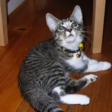

label=5 (cat)
Prediction: 1 (bicycle)


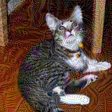

Prediction: 7 (clock)


In [ ]:
def adversarialPGD(
    model: torch.nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    epsilon: float = 4 / 255,
    alpha: float = 2 / 255,
    n_iters: int = 1,
    random_init: bool = False,
) -> torch.Tensor:
    """
    Find an input xᵃᵈᵛ within x±ε pushing `model(xᵃᵈᵛ)` away from y (maximizing loss, unless alpha is negative).

    Uses 'Projective Gradient Descent' with learning rate `alpha` and `n_iters` iterations, as introduced in:
    Madry et al., "Towards Deep Learning Models Resistant to Adversarial Attacks", ICRL 2018
    https://openreview.net/forum?id=rJzIBfZAb

    Assumes x is 0..1-valued and keeps it in these bounds (i.e., it expects unnormalized images).
    """
    was_training = model.training
    model.eval()
    x = x.clone().detach()
    with torch.no_grad():
        x_min = torch.clamp(x - epsilon, min=0)
        x_max = torch.clamp(x + epsilon, max=1)

        if random_init:
            x = x + torch.empty_like(x).uniform_(-epsilon, epsilon)
            x.clamp_(x_min, x_max)

    for _ in range(n_iters):
        x.requires_grad = True
        logits = model(x)
        loss = torch.nn.CrossEntropyLoss()(logits, y)
        with torch.no_grad():
            x_grad = torch.autograd.grad(loss, x)[0]
            # We could also:
            #   loss.backward()
            #   x_grad = x.grad.detach()
            # but then we'd nedd to temporarily set requires_grad=False on all model parameters.
            x = x.detach() + alpha * x_grad.sign()
            x.clamp_(x_min, x_max)
            x = x.detach()

    if was_training:
        model.train()
    return x.requires_grad_(False)


def example(device="cuda") -> None:
    model = get_model(eval=True).to(device)

    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[510]
    display_image_tensor(img)
    print(f"{label=} ({dataset.classes[label]})")

    img = img.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)
    pred = model(img)[0].argmax().item()
    print(f"Prediction: {pred} ({dataset.classes[pred]})")

    adv_img = normalize(adversarialPGD(model, unnormalize(img), label, epsilon=20 / 255, n_iters=100))
    display_image_tensor(adv_img[0])
    pred = model(adv_img)[0].argmax().item()
    print(f"Prediction: {pred} ({dataset.classes[pred]})")


example()


## Task 3: AdvProp

Training on adversarial examples unfortunately tends to decrease accuracy on plain (unmodified) images a lot.<br>
The authors of [Adversarial Examples Improve Image Recognition](https://arxiv.org/abs/1911.09665) hypothesize that<br>
this is because adversarial examples (and the model activations they induce) follow different distributions.<br>
They propose addressing that by using auxilliary batch-norm-s for the adversarial images.

#### 3a: Implementation
Read the paper and implement this technique. Note that:
* Parameters (weights and biases of the affine transform applied after normalizing) should be the same for plain and adversarial images; only the running mean and variance (the buffers) are distinct.
* During evaluation, the plain batch-norms should be used.
* Add the two losses from plain and adversarial images using weights that sum up to one, specifically: `0.75 * plain_loss + 0.25 * adversarial_loss`.
* You should not need to alter this and other hyperparameters; use the defaults of `Trainer.__init__()` and `adversarialPGD` (they are different than suggested in the paper, but work better in our case).
* See `get_model()` for an example of how layers can be replaced. You can assume all batch-norms are instances of `torch.nn.BatchNorm2d` (with `affine=True`, `track_running_stats=True`, and non-null `momentum`).

In [ ]:
### BEGIN SOLUTION
# Changing Layers to AdversialBatch
def replace_layer(model):
    for name, layer in model.named_children():
        if isinstance(layer, torch.nn.BatchNorm2d):
            setattr(model, name, AdversialBatch(layer).to(DEVICE))
        else:
            replace_layer(layer)


# Start batches in evaluate state
def start_adversial(model):
    for layer in model.modules():
        if isinstance(layer, AdversialBatch):
            layer.eval_true()


# Back to origin state
def end_adversial(model):
    for layer in model.modules():
        if isinstance(layer, AdversialBatch):
            layer.eval_false()


class AdversialBatch(torch.nn.Module):
    def __init__(self, init_bn):
        # instances of torch.nn.BatchNorm2d
        super(AdversialBatch, self).__init__()
        self.is_eval = False
        self.batch_normalization = deepcopy(init_bn)
        self.batch_normalization_adversial = deepcopy(init_bn)
        self.batch_normalization_adversial.reset_running_stats()
        self.register_buffer('number_batches', torch.tensor(0, dtype=torch.long))

    def forward(self, x):
        if self.is_eval:
            return self.batch_normalization(x)
        else:
            self.number_batches += 1
            if self.number_batches % 2 == 1:
                return self.batch_normalization_adversial(x)
            else:
                return self.batch_normalization(x)

    def eval_true(self):
        self.is_eval = True

    def eval_false(self):
        self.is_eval = False


### END SOLUTION

In [ ]:
class AdvPropTrainer(Trainer):
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = "cuda",
        n_iters: int = 1,
        epsilon: float = 4 / 255,
        alpha: float = 2 / 255,
        adv_ratio: float = 0.25,
    ):
        super().__init__(
            lr=lr, weight_decay=weight_decay, batch_norm_momentum=batch_norm_momentum, n_epochs=n_epochs, device=device
        )
        self.n_iters = n_iters
        self.epsilon = epsilon
        self.alpha = alpha
        self.adv_ratio = adv_ratio

    ### BEGIN SOLUTION
    # Mostly like in Trainer class
    def train(self, model: torch.nn.Module) -> dict[str, list[float]]:
        model = model.to(self.device)

        if self.batch_norm_momentum is not None:
            for m in model.modules():
                if isinstance(m, AdversialBatch):
                    m.batch_normalization.momentum = self.batch_norm_momentum
                    m.batch_normalization_adversial.momentum = self.batch_norm_momentum

        train_dataloader = self.get_train_dataloader()
        eval_dataloaders = self.get_eval_dataloaders()
        optimizer, lr_scheduler = self.get_optimizer_and_scheduler(model.parameters())

        start_adversial(model)
        results = {k: [] for k in eval_dataloaders.keys()}
        for k, v in self.do_evaluations(model, eval_dataloaders).items():
            results[k].append(v)
        end_adversial(model)

        for epoch in range(1, self.n_epochs + 1):
            self.train_epoch(model, train_dataloader, optimizer, epoch)
            lr_scheduler.step()

            start_adversial(model)
            for k, v in self.do_evaluations(model, eval_dataloaders).items():
                results[k].append(v)
            end_adversial(model)

        return results


    def train_epoch(self, model, dataloader, optimizer, epoch):
        model.train()
        n_total = 0
        n_correct = 0
        progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")
        for image_batch, label_batch in progress_bar:
            image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)
            adv_batch = normalize(adversarialPGD(
                model, unnormalize(image_batch), label_batch, epsilon=self.epsilon, alpha=self.alpha, n_iters=self.n_iters
                ).to(self.device))
            optimizer.zero_grad()

            plain_logistits = model(image_batch)
            adv_logits = model(adv_batch)
            plain_loss = torch.nn.CrossEntropyLoss()(plain_logistits, label_batch)
            adv_loss = torch.nn.CrossEntropyLoss()(adv_logits, label_batch)

            loss = (1 - self.adv_ratio) * plain_loss + self.adv_ratio * adv_loss
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                n_total += len(label_batch)
                n_correct += (plain_logistits.argmax(dim=1) == label_batch).sum().item()

            accuracy = n_correct / n_total
            progress_bar.set_postfix({"train-acc": f"{accuracy * 100:.1f} %", "lr": optimizer.param_groups[0]["lr"]})
        return accuracy
    ### END SOLUTION

#### 3b: Evaluation

Compare Trainer and AdvPropTrainer (using default hyperparameters, 10 epochs, in particular).<br>
(One training with Trainer / AdvPropTrainer takes roughly 15 / 20 minutes on colab GPU, respectively).<br>
Discuss the results in 1-3 sentences (consider proposing what could be tested further, with more time).

In [ ]:
### BEGIN SOLUTION

In [ ]:
print("Training with AdvPropTrainer")
model = get_model(eval=False)
replace_layer(model)
AdvPropTrainer().train(model)
start_adversial(model)
evaluate(model, alt_test_dataset)

print('\n')

print("Training with Trainer")
model = get_model(eval=False)
Trainer().train(model)
evaluate(model, alt_test_dataset)

Training with AdvPropTrainer
val=75.3 %	alt=36.8 %	


Train epoch   1: 100%|██████████| 79/79 [01:44<00:00,  1.33s/it, train-acc=63.4 %, lr=0.0002]


val=91.5 %	alt=53.3 %	


Train epoch   2: 100%|██████████| 79/79 [01:38<00:00,  1.25s/it, train-acc=73.2 %, lr=0.000194]


val=92.0 %	alt=55.7 %	


Train epoch   3: 100%|██████████| 79/79 [01:39<00:00,  1.26s/it, train-acc=74.7 %, lr=0.000188]


val=91.8 %	alt=55.9 %	


Train epoch   4: 100%|██████████| 79/79 [01:38<00:00,  1.25s/it, train-acc=76.7 %, lr=0.000183]


val=93.0 %	alt=56.9 %	


Train epoch   5: 100%|██████████| 79/79 [01:38<00:00,  1.25s/it, train-acc=78.0 %, lr=0.000177]


val=92.3 %	alt=57.0 %	


Train epoch   6: 100%|██████████| 79/79 [01:39<00:00,  1.27s/it, train-acc=79.0 %, lr=0.000172]


val=92.6 %	alt=57.7 %	


Train epoch   7: 100%|██████████| 79/79 [01:39<00:00,  1.26s/it, train-acc=80.0 %, lr=0.000167]


val=93.1 %	alt=57.4 %	


Train epoch   8: 100%|██████████| 79/79 [01:41<00:00,  1.28s/it, train-acc=80.6 %, lr=0.000162]


val=93.9 %	alt=57.7 %	


Train epoch   9: 100%|██████████| 79/79 [01:40<00:00,  1.27s/it, train-acc=81.2 %, lr=0.000157]


val=94.7 %	alt=58.0 %	


Train epoch  10: 100%|██████████| 79/79 [01:41<00:00,  1.28s/it, train-acc=81.3 %, lr=0.000152]


val=94.3 %	alt=56.3 %	


eval: 100%|██████████| 11/11 [00:13<00:00,  1.22s/it, accuracy=56.3 %]




Training with Trainer
val=75.3 %	alt=36.8 %	


Train epoch   1: 100%|██████████| 79/79 [01:30<00:00,  1.15s/it, train-acc=63.5 %, lr=0.0002]


val=91.1 %	alt=53.3 %	


Train epoch   2: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=72.4 %, lr=0.000194]


val=92.0 %	alt=55.5 %	


Train epoch   3: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=75.3 %, lr=0.000188]


val=92.2 %	alt=56.3 %	


Train epoch   4: 100%|██████████| 79/79 [01:21<00:00,  1.04s/it, train-acc=77.3 %, lr=0.000183]


val=92.5 %	alt=56.1 %	


Train epoch   5: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=77.8 %, lr=0.000177]


val=92.8 %	alt=55.2 %	


Train epoch   6: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=79.0 %, lr=0.000172]


val=93.6 %	alt=55.6 %	


Train epoch   7: 100%|██████████| 79/79 [01:22<00:00,  1.04s/it, train-acc=79.8 %, lr=0.000167]


val=93.4 %	alt=56.0 %	


Train epoch   8: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=81.0 %, lr=0.000162]


val=94.4 %	alt=55.6 %	


Train epoch   9: 100%|██████████| 79/79 [01:22<00:00,  1.04s/it, train-acc=81.4 %, lr=0.000157]


val=94.1 %	alt=55.6 %	


Train epoch  10: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=81.8 %, lr=0.000152]


val=94.3 %	alt=54.0 %	


eval: 100%|██████████| 11/11 [00:13<00:00,  1.20s/it, accuracy=54.0 %]


0.5403571428571429

**Discussion:**

Using standard Trainer, the model reaches its maximum accuracy on the alt_dataset as early as the third epoch, indicating rapid adaptation to the data. The use of AdvPropTrainer reduces over-fitting to the training data and improves predictions on the alt_dataset with same accuracy on val_dataset. This method effectively improves model performance and the next step should focus on identifying optimal hyperparameters, with special focus on adv_ratio.

In [ ]:
### END SOLUTION

## Task 4: SparseTopK

Another technique to improve robustness against style and pattern changes was proposed in
[Emergence of Shape Bias in CNNs through Activation Sparsity](https://openreview.net/forum?id=QzcZb3fWmW)
(you do not need to read the paper).
The idea is simple: in between some layers, enforce activation sparsity by zeroing out all but the top say 20% activations (by absolute value).
The hope is that the strong activations, which we keep, encode the more generalizable shape information.

More formally `SparseTopK`, for a fixed fraction $k$ like $20\%$, should be a module that for an input $x \in \mathbb{R}^{C \times H \times W}$ outputs:
$$ \begin{align*}
    x_{\text{out}}[c,h,w] &= x[c,h,w]\quad &&\text{ if } |x[c,h,w]| \geq \text{top-k-percentile}(x[c,:,:]) \\
                          &= 0 \quad &&\text{ otherwise}
\end{align*} $$

Your task is to:
* implement such a module below (for inputs of shape `(batch_size, C, H, W)`),
* run the example once (for 10 epochs),
* shortly discuss the result (one sentence).

In [ ]:
class SparseTopK(torch.nn.Module):
    def __init__(self, k: float):
        super().__init__()
        self.k = k
        assert 0 <= k <= 1, f"Expected 0 ≤ k ≤ 1, got {k}."

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ### BEGIN SOLUTION
        N, C, H, W = x.shape
        q = torch.quantile(x.view(N, C, -1).abs(), q=self.k, dim=2, keepdim=True)
        x = torch.where(torch.abs(x) >= q.unsqueeze(-1), x, torch.zeros_like(x))
        ### END SOLUTION
        return x


def example_sparse() -> None:
    model = get_model()
    # The paper tests on ResNet18 and suggests inserting one SparseTopK(0.2) module after the second layer.
    # We'll do something similar for our model, EfficientNetB0.
    model.features[1][0].block.insert(3, SparseTopK(0.2))

    Trainer().train(model)


example_sparse()

val=75.7 %	alt=36.2 %	


Train epoch   1: 100%|██████████| 79/79 [01:26<00:00,  1.10s/it, train-acc=63.1 %, lr=0.0002]


val=89.4 %	alt=54.5 %	


Train epoch   2: 100%|██████████| 79/79 [01:22<00:00,  1.05s/it, train-acc=72.7 %, lr=0.000194]


val=90.9 %	alt=54.7 %	


Train epoch   3: 100%|██████████| 79/79 [01:22<00:00,  1.04s/it, train-acc=74.1 %, lr=0.000188]


val=91.8 %	alt=56.6 %	


Train epoch   4: 100%|██████████| 79/79 [01:22<00:00,  1.04s/it, train-acc=76.6 %, lr=0.000183]


val=92.6 %	alt=55.2 %	


Train epoch   5: 100%|██████████| 79/79 [01:21<00:00,  1.04s/it, train-acc=77.8 %, lr=0.000177]


val=93.4 %	alt=54.8 %	


Train epoch   6: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=79.1 %, lr=0.000172]


val=93.9 %	alt=55.9 %	


Train epoch   7: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=79.6 %, lr=0.000167]


val=94.2 %	alt=56.1 %	


Train epoch   8: 100%|██████████| 79/79 [01:20<00:00,  1.01s/it, train-acc=79.9 %, lr=0.000162]


val=93.8 %	alt=55.3 %	


Train epoch   9: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=81.2 %, lr=0.000157]


val=95.0 %	alt=55.2 %	


Train epoch  10: 100%|██████████| 79/79 [01:20<00:00,  1.01s/it, train-acc=81.7 %, lr=0.000152]


val=94.9 %	alt=54.1 %	


`### BEGIN SOLUTION (discussion)`

---

SparseTopK achieves very similar results to simply training with standard Trainer.

---

`### END SOLUTION`